# Assignment 2

### Using the downsampling functions provided in class:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

# we won't use these packages directly, but the function that picks colors will
import scipy
import scipy.misc
import scipy.cluster

# If you haven't yet, you may need to install scipy
#!conda install -c anaconda scipy


# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

## Importing 1st image: lenna.png

In [93]:
im1 = Image.open('lenna.png')

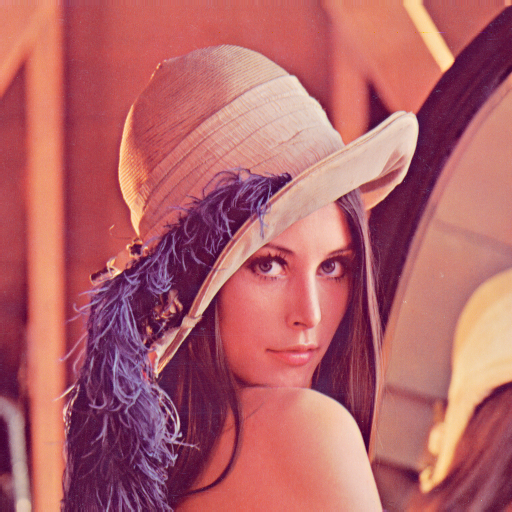

In [94]:
im1

Convert to an 8-color image for easier handling:

In [95]:
new_im1, new_rgbs1 = convert_image(im1, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[129.64337751  48.90086018  81.504257  ]
 [224.820955   153.21576778 132.2       ]
 [ 93.66501831  23.37991536  65.26002092]
 [154.19707898 101.60241616 138.46375766]
 [211.7800996  125.28700071 116.16820815]
 [231.08645025 193.58634439 171.24467184]
 [172.27777626  68.81087224  81.515076  ]
 [205.31623455  95.6829291   95.29476814]]


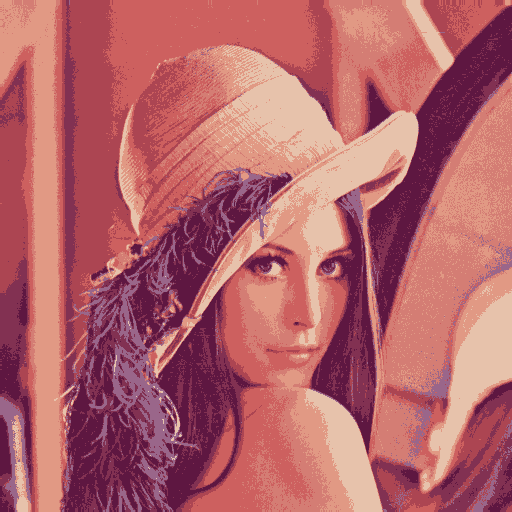

In [96]:
new_im1

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [97]:
new_im_data1 = np.array(new_im1)

In [98]:
np.unique(new_im_data1.reshape(-1, new_im_data1.shape[2]), axis=0)

array([[ 94,  23,  65],
       [130,  49,  82],
       [154, 102, 138],
       [172,  69,  82],
       [205,  96,  95],
       [212, 125, 116],
       [225, 153, 132],
       [231, 194, 171]], dtype=uint8)

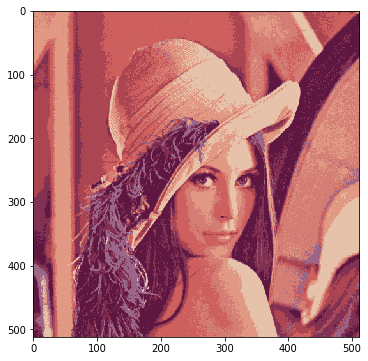

In [99]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(new_im_data1)
plt.show()

Let's make a histogram of all of the colors.  We have to do a bit more preprocessing, BUT its all stuff we've kind of already done.

In [100]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [101]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [102]:
unique_colors = np.unique(new_im_data1.reshape(-1, new_im_data1.shape[2]), axis=0)
unique_colors

array([[ 94,  23,  65],
       [130,  49,  82],
       [154, 102, 138],
       [172,  69,  82],
       [205,  96,  95],
       [212, 125, 116],
       [225, 153, 132],
       [231, 194, 171]], dtype=uint8)

In [103]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data1[:,:,0] == rgb[0] 
    greens_mask = new_im_data1[:,:,1] == rgb[1]
    blues_mask = new_im_data1[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data1[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

In [18]:
color_labels

['Color #0',
 'Color #1',
 'Color #2',
 'Color #3',
 'Color #4',
 'Color #5',
 'Color #6',
 'Color #7']

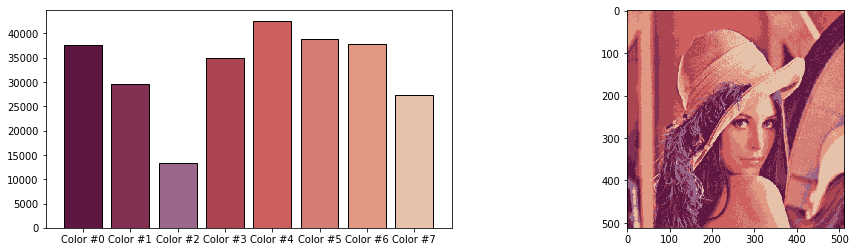

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data1)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

## Importing 2nd image: cameraman.png

In [115]:
im2 = Image.open('cameraman.png')

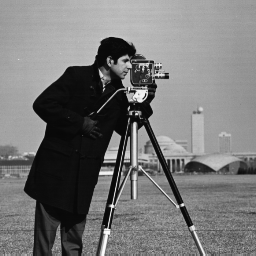

In [116]:
im2

Convert to an 8-color image for easier handling:

In [29]:
new_im2, new_rgbs2 = convert_image(im2, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[148.47701479 148.47701479 148.47701479]
 [223.05614973 223.05614973 223.05614973]
 [164.48724967 164.48724967 164.48724967]
 [102.97464633 102.97464633 102.97464633]
 [127.59668313 127.59668313 127.59668313]
 [ 55.50886408  55.50886408  55.50886408]
 [180.71972896 180.71972896 180.71972896]
 [ 14.37934009  14.37934009  14.37934009]]


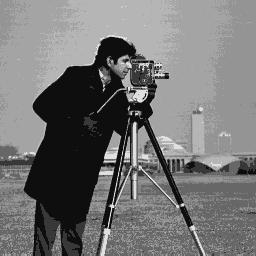

In [30]:
new_im2

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [31]:
new_im_data2 = np.array(new_im2)

In [32]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [33]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [34]:
unique_colors = np.unique(new_im_data2.reshape(-1, new_im_data2.shape[2]), axis=0)
unique_colors

array([[ 14,  14,  14],
       [ 56,  56,  56],
       [103, 103, 103],
       [128, 128, 128],
       [148, 148, 148],
       [164, 164, 164],
       [181, 181, 181],
       [223, 223, 223]], dtype=uint8)

In [35]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data2[:,:,0] == rgb[0] 
    greens_mask = new_im_data2[:,:,1] == rgb[1]
    blues_mask = new_im_data2[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data2[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

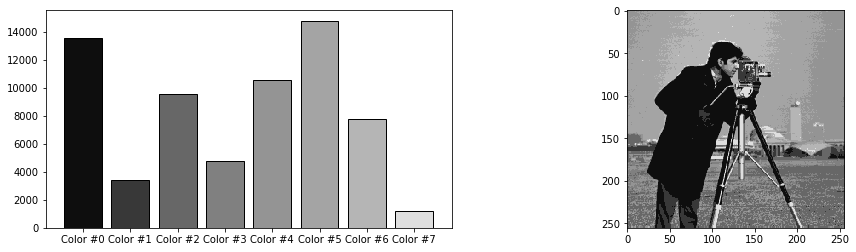

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data2)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

## Importing 3rd image: brain.jpg

In [66]:
im3 = Image.open('skin_lesion.jpg')

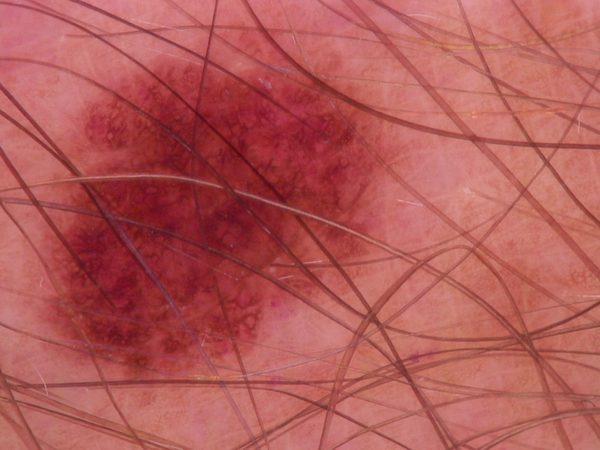

In [67]:
im3

Convert to an 8-color image for easier handling:

In [69]:
new_im3, new_rgbs3 = convert_image(im3, ncolors = 8)

finding 8 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[123.83495364  29.54095778  37.68237465]
 [172.06921976  80.9956335   77.75540444]
 [159.59659333  62.03829589  63.5003298 ]
 [201.57709371 117.8023019  112.74666352]
 [184.63005264  95.97616845  90.86517786]
 [208.52362412 127.01894139 125.53200744]
 [194.10445076 108.97505776 101.85392431]
 [145.09853485  43.92255148  48.50488384]]


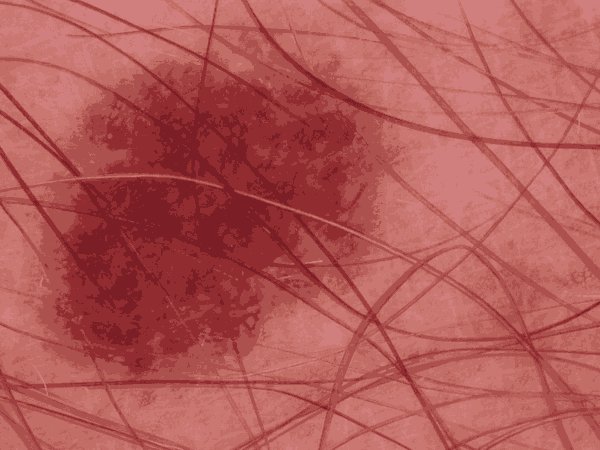

In [71]:
new_im3

We can check that our conversion worked by printing out the unique colors in our new image (note the change to integer values here, as expected by an RGB color map):

In [79]:
new_im_data3 = np.array(new_im3)

In [80]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [81]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [82]:
unique_colors = np.unique(new_im_data3.reshape(-1, new_im_data3.shape[2]), axis=0)
unique_colors

array([[124,  30,  38],
       [145,  44,  49],
       [160,  62,  64],
       [172,  81,  78],
       [185,  96,  91],
       [194, 109, 102],
       [202, 118, 113],
       [209, 127, 126]], dtype=uint8)

In [83]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data3[:,:,0] == rgb[0] 
    greens_mask = new_im_data3[:,:,1] == rgb[1]
    blues_mask = new_im_data3[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data3[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

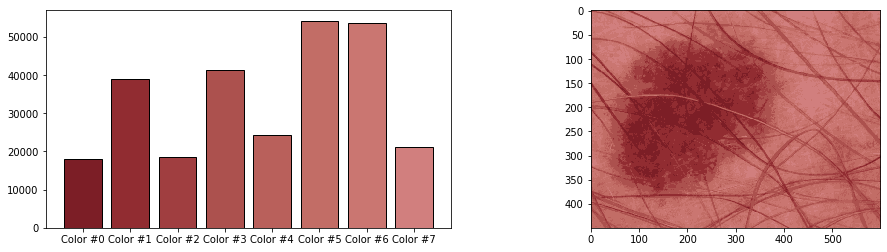

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data3)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

## Converting all images to same color sequence for better comparison

In [105]:
new_im11, new_rgbs11 = convert_image_specific(im1, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

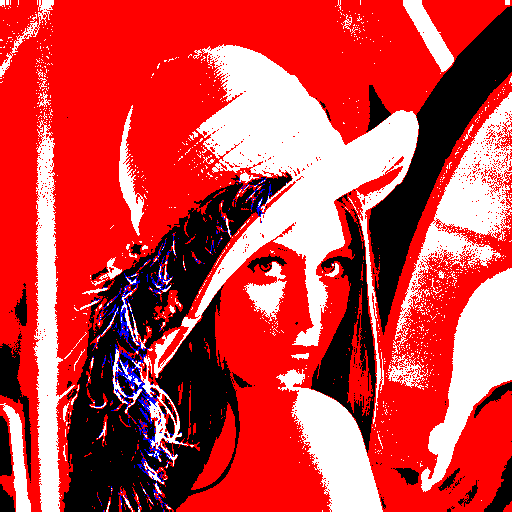

In [106]:
new_im11

In [107]:
new_im_data11 = np.array(new_im11)

In [108]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [109]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [110]:
unique_colors = np.unique(new_im_data11.reshape(-1, new_im_data11.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [  0,   0, 255],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [111]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data11[:,:,0] == rgb[0] 
    greens_mask = new_im_data11[:,:,1] == rgb[1]
    blues_mask = new_im_data11[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data11[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

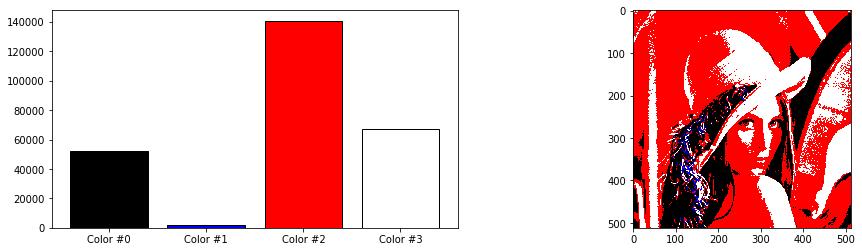

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data11)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

In [117]:
new_im22, new_rgbs22 = convert_image_specific(im2, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

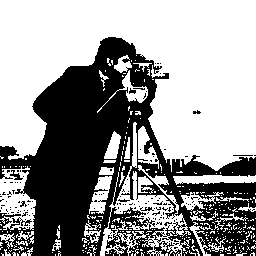

In [118]:
new_im22

In [119]:
new_im_data22 = np.array(new_im22)

In [120]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [121]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [122]:
unique_colors = np.unique(new_im_data22.reshape(-1, new_im_data22.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [123]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data22[:,:,0] == rgb[0] 
    greens_mask = new_im_data22[:,:,1] == rgb[1]
    blues_mask = new_im_data22[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data22[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

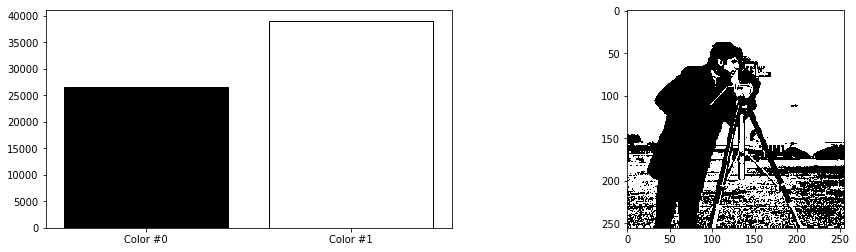

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data22)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()

In [125]:
new_im33, new_rgbs33 = convert_image_specific(im3, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ])

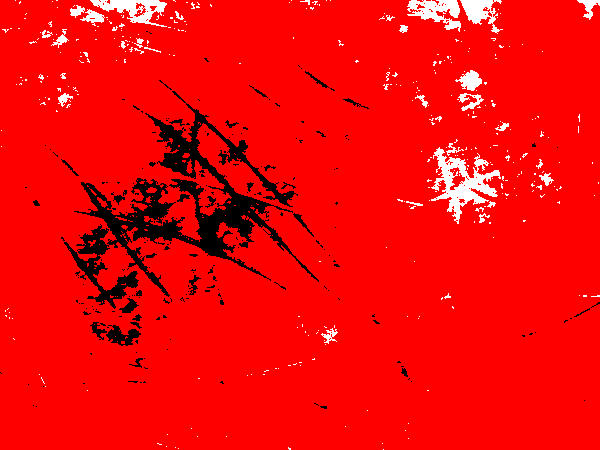

In [126]:
new_im33

In [127]:
new_im_data33 = np.array(new_im33)

In [128]:
myList = [] # start with an empty list
for i in range(3):
    myList.append(i)
myList

[0, 1, 2]

In [129]:
number_of_pixels_of_a_color = [] # num of pixels at a particular color
color_labels = [] # how we label those colors on our histogram
color_values = [] # RGBA sequences

In [130]:
unique_colors = np.unique(new_im_data33.reshape(-1, new_im_data33.shape[2]), axis=0)
unique_colors

array([[  0,   0,   0],
       [255,   0,   0],
       [255, 255, 255]], dtype=uint8)

In [131]:
for icolor,rgb in enumerate(unique_colors):
    #print(icolor, rgba)
    # we want to count pixels with whatever rgba combination
    # step 1: mask out pixels at a particular color
    reds_mask = new_im_data33[:,:,0] == rgb[0] 
    greens_mask = new_im_data33[:,:,1] == rgb[1]
    blues_mask = new_im_data33[:,:,2] == rgb[2]

    pixel_mask = reds_mask & greens_mask & blues_mask
    
    # step 2: count up all pixels
    npixels = len(new_im_data33[pixel_mask])
    
    # store the number of pixels for this rgba combo
    number_of_pixels_of_a_color.append(npixels) # appending to a list obj.
    # also want to name these colors
    color_labels.append("Color #" + str(icolor))
    # last thing: color values
    color_values.append(rgb/255) # this is converting to matplotlib bar

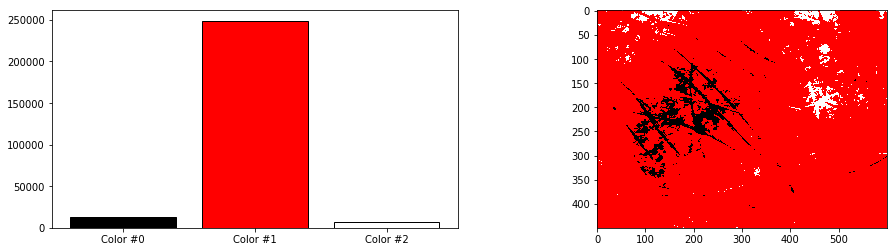

In [132]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

myBarChart = ax[0].bar(color_labels, number_of_pixels_of_a_color) # now I have a *vector* of axes
ax[1].imshow(new_im_data33)

# set colors of each bar individually
for i in range(len(myBarChart)): # for all bars in my barchart
    myBarChart[i].set_color(color_values[i])
    myBarChart[i].set_edgecolor('black')
    
plt.show()